In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")

Veriyi Dahil Etme

In [13]:
class veri(Dataset): #dataset classı pytorch un veriyi eklemek için kullandırttığı bir classdır.
    def __init__(self, csv_file, root_dir, transform=None): #csv_file fotograflarımızın adreslerinin yer aldığı dosyadır onun pathini vermemiz gerekiyor. root_dir fotograflarımızın oldugu klasörün adresidir
        self.annotations=pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
       img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
       image=io.imread(img_path)
       y_label=torch.tensor(int(self.annotations.iloc[index,1]))
       
       if self.transform:
              image=self.transform(image)
              return (image,y_label)

Veriyi Hazırlama

In [14]:
dataset=veri(csv_file="D:\\udemy_data\\f1_classification\\f111.csv",root_dir="D:\\udemy_data\\f1_classification",
transform=torchvision.transforms.Compose([ #compose metodu birden fazla transform işlemini tek seferde yapmamıza olanak tanır.
    transforms.ToTensor(), #tensore cevirmemizi sağlar verimizi
    transforms.Resize(size=(28,28)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

Veri Ön İşleme

In [15]:
train_set,test_set=torch.utils.data.random_split(dataset,[200,79]) # verimizin 200 ü train geri kalan 79 tanesi test için ayrıldı
train_loader=DataLoader(dataset=train_set,batch_size=1,shuffle=False)
test_loader=DataLoader(dataset=test_set,batch_size=1,shuffle=False)

Veriyi Görselleştirme

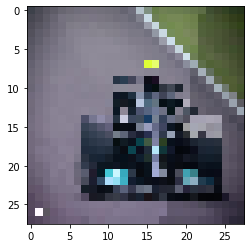

Mercedes
torch.Size([1, 3, 28, 28])


In [16]:
import matplotlib.pyplot as plt
import numpy as np
batch_size=1
classes=["Ferrari","Mclaren","Mercedes","Redbull"]

def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
dataiter=iter(train_loader)
images,labels=dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("".join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())



Model Mimarisini Oluşturma

In [17]:
class Net(nn.Module): #model yapısı class içinde oluşturulur ilk 3 satır pytochda class için temel tanımlamalardır.
    def __init__(self):
        super(Net,self).__init__()
        #conv katmanları:
        self.conv1=nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5)) #giriş kanalı, çıkış kanalı ve kernel size ı tanımladık atride(adım) gibi tanımlamaları default değerde bıraktık.
        self.conv2=nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3))
        self.conv3=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2))
        self.conv4=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2))
        #max pooling katmanı:

        self.max=nn.MaxPool2d(kernel_size=(2,2)) # bu katman her conv dan sonra çalışıcak bağlama kısmında belirtiyoruz. Buraya birden fazla maxpool fonksiyonu tanımlayıp bağlama fonksiyonunda onlarıda kullanabiliriz.

        #aktivasyon fonksiyonu:
        self.func=nn.ELU()

        #fully connected laerımız: ("tensorflowda dense diye geçiyor")
        self.fc1=nn.Linear(in_features=32,out_features=50) #conv katmanından en son 32 kanal çıktıgı için girişi 32 ile başlattık.
        self.fc2=nn.Linear(in_features=50,out_features=50)
        self.fc3=nn.Linear(in_features=50,out_features=100)
        self.fc4=nn.Linear(in_features=100,out_features=4) # son çıktı katmanımız 4 formula aracı oldugu için 4 çıkışlı yaptık.

    def forward(self,x): # bu fonksiyon bağlama fonksiyonudur oluşturdugumuz katmanlar birbirine bağlı değil bu fonksiyon ile bağlama işlmeini geçekleştiriyoruz.
         x=self.conv1(x) #conv katmanının çıkışını aktivasyon fonksiyonuna onuda maxpool a gönderiyoruz sonuncu conv katmanının çıkışında maxpool yok
         x=self.func(x)
         x=self.max(x)

         x=self.conv2(x)
         x=self.func(x)
         x=self.max(x)

         x=self.conv3(x)
         x=self.func(x)
         x=self.max(x)

         x=self.conv4(x)
         x=self.func(x)

         x=x.view(x.size(0),-1) #flatten: düzleştirme işlemi

         x=self.fc1(x)
         x=self.func(x)
         x=self.fc2(x)
         x=self.func(x)
         x=self.fc3(x)
         x=self.func(x)
         x=self.fc4(x)
            
         return x
          




Modelin Eğitimi

In [18]:
#tensorflowda fit metoduyla yaptıgımız işlem.

start=time.time() # zamınımızı tutacak yapmasakta olur

model=Net() # yukarda tanımladıgımız classı çağırıyoruz

optimizer=torch.optim.Adamax(model.parameters(),lr=0.001) #optimizasyon fonksiyonumuzu belirliyoruz. İçerisine modelimizin parametrelerini ve learning rate değerimizi giriyoruzki ağırlıkları güncelleyebilsin.

error=torch.nn.CrossEntropyLoss() #loss fonksiyonumuzu belirledik

epoch = 10

for j in range(epoch):
    for i,(images,label) in enumerate (train_loader):

        optimizer.zero_grad() # her bir epoch sonunda türev değerlini sıfırlıyor. Ağırlıklara göre her bir epocta yeni bir türev değeri hesaplıyor.
        tahmin=model(images)
        loss=error(tahmin,label)
        loss.backward() # kayıp değerine göre geri yayılımı uyguluyoruz.
        optimizer.step() #zero_grad, backward ve step fonksiyonları olmazla olmaz fonksiyonlar. step sonraki adıma geçmemizi sağlıyor.

        print("Epoch [{}/{}],loss:{:.4f}".format(j+1,i+1,loss.item()))
end=time.time()
print("süre:",end-start)



Epoch [1/1],loss:1.3900
Epoch [1/2],loss:1.3586
Epoch [1/3],loss:1.3395
Epoch [1/4],loss:1.3723
Epoch [1/5],loss:1.3047
Epoch [1/6],loss:1.2818
Epoch [1/7],loss:1.2656
Epoch [1/8],loss:1.3272
Epoch [1/9],loss:1.3291
Epoch [1/10],loss:1.2065
Epoch [1/11],loss:1.1904
Epoch [1/12],loss:1.7558
Epoch [1/13],loss:1.7496
Epoch [1/14],loss:1.1531
Epoch [1/15],loss:1.7507
Epoch [1/16],loss:1.4295
Epoch [1/17],loss:1.7480
Epoch [1/18],loss:1.7340
Epoch [1/19],loss:1.4423
Epoch [1/20],loss:1.4361
Epoch [1/21],loss:1.6865
Epoch [1/22],loss:1.6738
Epoch [1/23],loss:1.3759
Epoch [1/24],loss:1.4190
Epoch [1/25],loss:1.4201
Epoch [1/26],loss:1.3864
Epoch [1/27],loss:1.6165
Epoch [1/28],loss:1.1918
Epoch [1/29],loss:1.3953
Epoch [1/30],loss:1.3947
Epoch [1/31],loss:1.2058
Epoch [1/32],loss:1.2108
Epoch [1/33],loss:1.3937
Epoch [1/34],loss:1.5784
Epoch [1/35],loss:1.2128
Epoch [1/36],loss:1.5791
Epoch [1/37],loss:1.5659
Epoch [1/38],loss:1.4104
Epoch [1/39],loss:1.5627
Epoch [1/40],loss:1.2239
Epoch [1/

Model Testi

In [19]:

def dogruluk(loader,model):
    num_correct=0
    num_samples=0
    model.eval()#modeli test edicez

    with torch.no_grad(): #burda modelimizi eğitmediğimiz için türevleri hesaplatmıcaz
        for x,y in loader:
            tahmin=model(x)
            _,pred=tahmin.max(1)
            num_correct+=(pred==y).sum() #tahmin değerimizi y' ye eşitse correcti 1 artıracak
            num_samples+=pred.size(0)
            
        print(f"Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        model.train()



In [20]:
print("train dogruluk:")
dogruluk(train_loader,model)
print("test dogruluk:")
dogruluk(test_loader,model)


train dogruluk:
Got 154/200 with accuracy 77.00
test dogruluk:
Got 53/79 with accuracy 67.09


Modelin Eğitimi ve Testi

In [9]:
# bu kısımda model eğitilirken aynı zamanda testide yaptıgımız kısımdır. Bu aşamayı kullanırken önceki iki aşamaya gerek kalmıyor.

start=time.time() 

model=Net() 

optimizer=torch.optim.Adam(model.parameters(),lr=0.001) 

error=torch.nn.CrossEntropyLoss() 

epoch = 10

kayıp=[] #loss bilgimizi eklicez
count=0
iterasyon=[] #iterasyonları buna eklicez
for i in range(epoch):
    for i,(images,label) in enumerate(train_loader):
        tahmin=model(images)
        optimizer.zero_grad()
        loss=error(tahmin,label)
        loss.backward()
        optimizer.step()

        count+=1

        if count % 100 == 0:
            total=0
            correct=0
            correct_hata=0
            for image,labels in test_loader:
                out=model(image)
                pred=torch.max(out.data,1)[1]
                total+=len(label)

                correct+=(pred==labels).sum() #doğru sayımız
                correct_hata+=(pred!=labels).sum() # yanlış sayımız
            dogruluk=100*correct/float(total)
            hata=100*correct_hata/float(total)

            kayıp.append(loss.data)
            iterasyon.append(count)

        if count % 100 == 0:
            print('Iteration: {} loss: {} accuracy: {:.2f}% Error: {:.2f}%'.format(count,loss.data,dogruluk,hata))


        

end=time.time()
print("süre:",end-start)

Iteration: 100 loss: 1.431093454360962 accuracy: 48.10% Error: 51.90%
Iteration: 200 loss: 0.9139726758003235 accuracy: 56.96% Error: 43.04%
Iteration: 300 loss: 1.1586244106292725 accuracy: 62.03% Error: 37.97%
Iteration: 400 loss: 0.09702415019273758 accuracy: 60.76% Error: 39.24%
Iteration: 500 loss: 1.006575107574463 accuracy: 62.03% Error: 37.97%
Iteration: 600 loss: 0.047033362090587616 accuracy: 58.23% Error: 41.77%
Iteration: 700 loss: 1.1262098550796509 accuracy: 65.82% Error: 34.18%
Iteration: 800 loss: 0.08997895568609238 accuracy: 62.03% Error: 37.97%
Iteration: 900 loss: 0.5614885687828064 accuracy: 77.22% Error: 22.78%
Iteration: 1000 loss: 0.08382895588874817 accuracy: 67.09% Error: 32.91%
Iteration: 1100 loss: 0.3654977083206177 accuracy: 75.95% Error: 24.05%
Iteration: 1200 loss: 0.015043382532894611 accuracy: 60.76% Error: 39.24%
Iteration: 1300 loss: 0.2500057816505432 accuracy: 74.68% Error: 25.32%
Iteration: 1400 loss: 0.21667613089084625 accuracy: 70.89% Error: 29

Model Save

In [10]:
torch.save(model,"udemy1.pth") #modeli kaydetme
torch.save(model.state_dict(),"udemy11.pth") #modelin sadece ağırlıklarını kaydetme

Model Load

In [22]:
model1=torch.load("udemy1.pth")

In [24]:
model11=Net() #ağırlıkları kullanarak laod etme (tekrar classımızı çağırıp eval ile modeli çağırıyoruz)
model11.load_state_dict(torch.load("udemy11.pth"))
model11.eval()


Net(
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (max): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (func): ELU(alpha=1.0)
  (fc1): Linear(in_features=32, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=4, bias=True)
)

In [23]:
print("train dogruluk:")
dogruluk(train_loader,model1)
print("test dogruluk:")
dogruluk(test_loader,model1)

train dogruluk:
Got 179/200 with accuracy 89.50
test dogruluk:
Got 69/79 with accuracy 87.34
